# Example - Building Permits

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Create-a-target" data-toc-modified-id="Create-a-target-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Create a target</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Domain classifier</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from models.aux_functions import *

np.random.seed(42)

In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
DATASETS_PATH = "~/Documents/datasets/sf_building_permits/"
PREFIX = "building_permits"

In [5]:
data = pd.read_csv(DATASETS_PATH + "Building_Permits.csv", engine="python")

In [6]:
data.shape

(198900, 43)

In [7]:
data.nunique()

Permit Number                             181495
Permit Type                                    8
Permit Type Definition                         8
Permit Creation Date                        1291
Block                                       4896
Lot                                         1055
Street Number                               5099
Street Number Suffix                          18
Street Name                                 1704
Street Suffix                                 21
Unit                                         660
Unit Suffix                                  164
Description                               134272
Current Status                                14
Current Status Date                         1307
Filed Date                                  1288
Issued Date                                 1289
Completed Date                              1300
First Construction Document Date            1288
Structural Notification                        1
Number of Existing S

In [8]:
data.dtypes

Permit Number                              object
Permit Type                                 int64
Permit Type Definition                     object
Permit Creation Date                       object
Block                                      object
Lot                                        object
Street Number                               int64
Street Number Suffix                       object
Street Name                                object
Street Suffix                              object
Unit                                      float64
Unit Suffix                                object
Description                                object
Current Status                             object
Current Status Date                        object
Filed Date                                 object
Issued Date                                object
Completed Date                             object
First Construction Document Date           object
Structural Notification                    object


In [9]:
print(data["Permit Creation Date"].min())
print(data["Permit Creation Date"].max())

01/02/2013
12/31/2015


In [10]:
data["Permit Creation Date"] = pd.to_datetime(data["Permit Creation Date"])

In [11]:
data["Year"] = data["Permit Creation Date"].apply(lambda x: int(x.year))

## Create a target

Let's create if the animal was adopted in the following 6 months.

In [12]:
data["Site Permit"].unique()

array([nan, 'Y'], dtype=object)

In [13]:
data["target"] = (data["Site Permit"] == "Y").astype(int)

In [14]:
data["target"].mean()

0.026943187531422826

## Modeling

### Data

In [15]:
TIME_COLUMN = "Year"
TARGET = "target"

In [16]:
columns_to_label_encode = ["Street Suffix", 
                           "Proposed Use",
                           "Unit Suffix",
                           "Fire Only Permit",
                           "Existing Use",
                           "Neighborhoods - Analysis Boundaries"]

In [17]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

Street Suffix
Proposed Use
Unit Suffix


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fire Only Permit
Existing Use
Neighborhoods - Analysis Boundaries


In [18]:
numerical_features = ["Number of Existing Stories",
                      "Number of Proposed Stories",
                      "Supervisor District",
                      "Plansets",
                      "Estimated Cost",
                      "Existing Units",
                      "Proposed Units",
                      "Proposed Construction Type",
                      "Existing Construction Type"]

In [19]:
features = columns_to_label_encode + numerical_features
features = list(set(features))

In [20]:
data["Year"].value_counts()

2017    41156
2015    40150
2016    39721
2014    36686
2013    35228
2018     5937
2012       22
Name: Year, dtype: int64

In [21]:
data = data[~data["Year"].isin([2012])]

In [22]:
data["Year"].value_counts()

2017    41156
2015    40150
2016    39721
2014    36686
2013    35228
2018     5937
Name: Year, dtype: int64

In [23]:
data["Year"].max()

2018

In [24]:
training_start_year = 2013
training_end_year = 2015
holdout_end_year = 2018

In [25]:
in_time = data[data["Year"] <= training_end_year]
in_time = in_time[in_time["Year"] >= training_start_year]
out_of_time = data[data["Year"] > training_end_year]

In [26]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [27]:
train.shape

(89651, 45)

In [28]:
test.shape

(22413, 45)

In [29]:
out_of_time.shape

(86814, 45)

In [30]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Checking the support in the different environments

In [31]:
check_categoricals_match(train, columns_to_label_encode, "Year")

Year
2013    0.9
2014    0.9
2015    0.9
Name: Street Suffix, dtype: float64
Year
2013    0.872340
2014    0.893617
2015    0.797872
Name: Proposed Use, dtype: float64
Year
2013    0.620370
2014    0.509259
2015    0.546296
Name: Unit Suffix, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Fire Only Permit, dtype: float64
Year
2013    0.880435
2014    0.880435
2015    0.815217
Name: Existing Use, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Neighborhoods - Analysis Boundaries, dtype: float64


0.8619912594267616

In [32]:
check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=10)

Year
2013    0.9
2014    0.9
2015    0.9
Name: Number of Existing Stories_quant, dtype: float64
Year
2013    0.9
2014    1.0
2015    0.9
Name: Number of Proposed Stories_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Supervisor District_quant, dtype: float64
Year
2013    0.5
2014    0.5
2015    1.0
Name: Plansets_quant, dtype: float64
Year
2013    0.500
2014    0.625
2015    0.750
Name: Estimated Cost_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Existing Units_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Proposed Units_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Proposed Construction Type_quant, dtype: float64
Year
2013    1.0
2014    1.0
2015    1.0
Name: Existing Construction Type_quant, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.9027777777777778

### Benchmark

In [33]:
from pycaret.classification import *

In [34]:
clf1 = setup(train[features + [TARGET]], 
             target="target",
             session_id=1, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

In [35]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=7, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=-1,
                       oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [36]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [37]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt"]))

0.9741628772803965
0.9705868749030202
0.9592514706769399


In [38]:
benchmark_model = RandomForestClassifier(n_estimators=250, max_depth=8)
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [39]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

0.9729444173477386
0.9661060960064028
0.9574443300174347


In [40]:
# benchmark_importances = benchmark_model.feature_importances_
# benchmark_importances = pd.Series(benchmark_importances, index=features)
# benchmark_importances.rename("RF", inplace=True)

In [41]:
results = reverse_learning_curve(train, out_of_time, tuned_rf, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5)

In [42]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)

Proposed Units                         0.009124
Street Suffix                         -0.007856
Fire Only Permit                       0.000000
Number of Existing Stories             0.001908
Plansets                               0.001268
Existing Units                         0.020381
Neighborhoods - Analysis Boundaries   -0.000531
Proposed Construction Type             0.000000
Existing Use                           0.013289
Number of Proposed Stories             0.001186
Estimated Cost                         0.173993
Existing Construction Type             0.017988
Supervisor District                    0.002002
Unit Suffix                            0.000000
Proposed Use                          -0.004483
Name: RF, dtype: float64

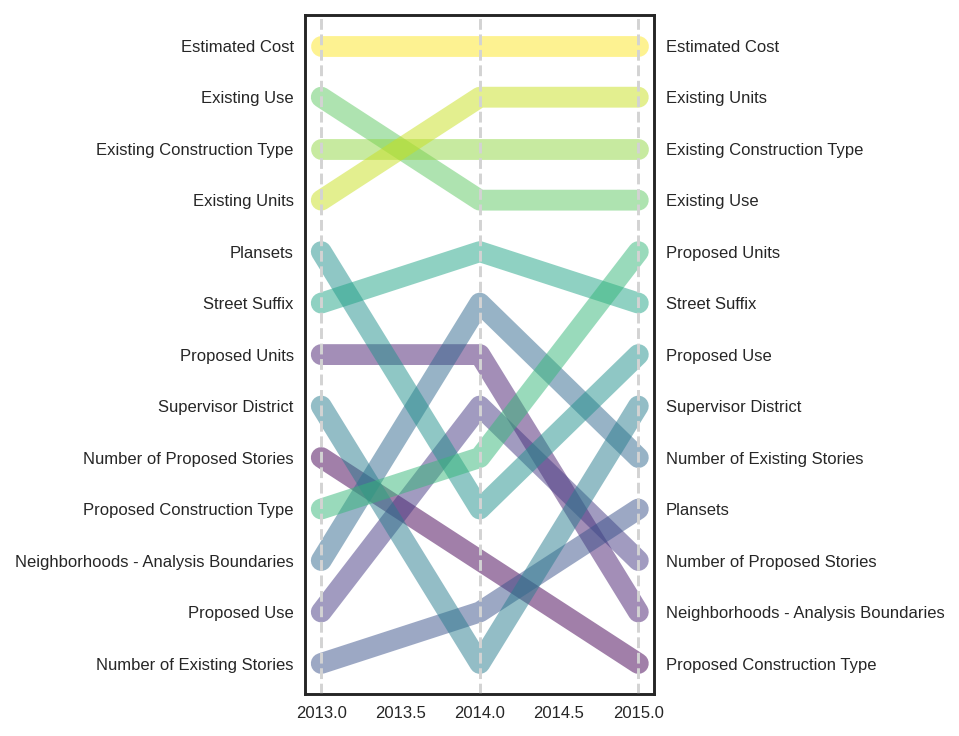

In [43]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

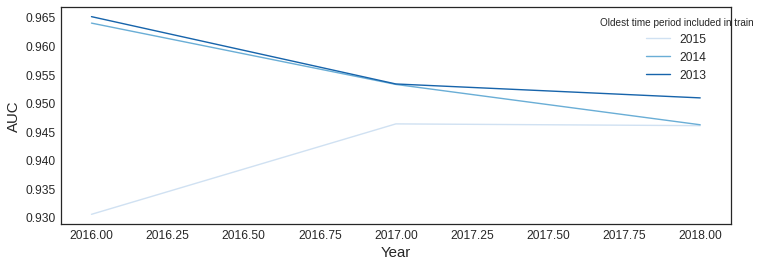

In [44]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [45]:
results

{'round': [],
 'holdout_performance': [0.9381299948804611,
  0.9583548156586392,
  0.9592514706769399],
 'feature_importance': [Proposed Units                        -0.002820
  Street Suffix                         -0.006493
  Fire Only Permit                       0.000000
  Number of Existing Stories             0.000000
  Plansets                               0.009374
  Existing Units                         0.010879
  Neighborhoods - Analysis Boundaries    0.000393
  Proposed Construction Type             0.000462
  Existing Use                           0.060662
  Number of Proposed Stories             0.001410
  Estimated Cost                         0.164602
  Existing Construction Type             0.025073
  Supervisor District                    0.002358
  Unit Suffix                            0.000000
  Proposed Use                           0.000135
  Name: 2015, dtype: float64,
  Proposed Units                         0.000000
  Street Suffix                         -0.0

## Challenger model

In [46]:
train.reset_index(drop=True, inplace=True)

In [47]:
train[features + [TIME_COLUMN]]

Proposed Units  Street Suffix  Fire Only Permit  \
0                 2.0              1                 0   
1                 1.0             17                 0   
2                 2.0             17                 1   
3                 1.0             17                 0   
4                 1.0             17                 0   
...               ...            ...               ...   
89646             1.0             17                 0   
89647             1.0              5                 0   
89648            64.0              1                 0   
89649             1.0             17                 0   
89650             2.0             17                 0   

       Number of Existing Stories  Plansets  Existing Units  \
0                             3.0       2.0             2.0   
1                             2.0       0.0             1.0   
2                             3.0       2.0             1.0   
3                             3.0       2.0             1.0   
4                             3.0       2.0             1.0   
...                           ...       ...             ...   
89646                         3.0       2.0             1.0   
89647                         2.0       0.0             1.0   
89648                         7.0       2.0            64.0   
89649                         2.0       0.0             1.0   
89650                         3.0       2.0             2.0   

       Neighborhoods - Analysis Boundaries  Proposed Construction Type  \
0                                       18                         5.0   
1                                        2                         5.0   
2                                       34                         5.0   
3                                        2                         5.0   
4                                       23                         5.0   
...                                    ...                         ...   
89646                                   31                         5.0   
89647                                   40                         5.0   
89648                                   16                         3.0   
89649                                   33                         5.0   
89650                                    2                         5.0   

       Existing Use  Number of Proposed Stories  Estimated Cost  \
0                 1                         3.0           100.0   
1                 0                         2.0         10000.0   
2                88                         4.0          5000.0   
3                72                         3.0           500.0   
4                 2                         3.0         10000.0   
...             ...                         ...             ...   
89646             0                         3.0             1.0   
89647             0                         2.0          3500.0   
89648             9                         7.0          6500.0   
89649             0                         2.0          4800.0   
89650             1                         3.0             1.0   

       Existing Construction Type  Supervisor District  Unit Suffix  \
0                             5.0                  9.0          107   
1                             5.0                  8.0          107   
2                             5.0                  6.0          107   
3                             5.0                  8.0          107   
4                             5.0                  3.0          107   
...                           ...                  ...          ...   
89646                         5.0                  2.0          107   
89647                         5.0                  7.0          107   
89648                         3.0                  2.0          107   
89649                         5.0                  2.0          107   
89650                         5.0                  8.0          107   

      

In [48]:
train["Year"].value_counts()

2015    32182
2014    29331
2013    28138
Name: Year, dtype: int64

In [49]:
CHALLENGER_MAX_DEPTH = 7
CHALLENGER_N_ESTIMATORS = 90
CHALLENGER_MIN_SAMPLES_BY_PERIODS = 2

In [50]:
challenger_model_max = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        period_criterion='max',
                                        multi=True)

challenger_model_max.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

In [51]:
train["challenger_prediction_max"] = challenger_model_max.predict_proba(train[features])[:, 1]
test["challenger_prediction_max"] = challenger_model_max.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction_max"] = challenger_model_max.predict_proba(out_of_time[features])[:, 1]

In [52]:
print(roc_auc_score(train[TARGET], train["challenger_prediction_max"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction_max"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction_max"]))

0.9664478466274868
0.9636565273202561
0.9557110106527542


In [53]:
challenger_model_max.feature_importance()

challenger_model_max_importances = challenger_model_max.feature_importance()
challenger_model_max_importances.rename("TRF Max", inplace=True)

Estimated Cost                         1079
Proposed Units                          662
Existing Use                            644
Neighborhoods - Analysis Boundaries     597
Number of Existing Stories              562
Proposed Use                            546
Number of Proposed Stories              541
Street Suffix                           499
Existing Units                          466
Supervisor District                     422
Plansets                                320
Proposed Construction Type              225
Existing Construction Type              190
Fire Only Permit                        179
Unit Suffix                              28
Name: TRF Max, dtype: int64

In [54]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [55]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

0.9663013818124946
0.9627290484813253
0.9547680768794912


## Feature Importance migration

In [56]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=CHALLENGER_MIN_SAMPLES_BY_PERIODS,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)

results_trt = reverse_learning_curve(train, out_of_time, challenger_model, features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, trt_model=True)

In [57]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)

Proposed Units                         5.146069e-02
Street Suffix                         -1.040072e-04
Fire Only Permit                       2.808544e-03
Number of Existing Stories             1.561736e-02
Plansets                               6.507361e-02
Existing Units                         9.027480e-03
Neighborhoods - Analysis Boundaries    4.922680e-03
Proposed Construction Type             4.327573e-03
Existing Use                           1.221938e-01
Number of Proposed Stories             5.573766e-02
Estimated Cost                         9.114829e-02
Existing Construction Type             7.527510e-03
Supervisor District                    5.742769e-03
Unit Suffix                           -4.440892e-17
Proposed Use                           1.340449e-01
Name: TRF, dtype: float64

In [58]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_max_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

RF           TRF  TRF Max
Proposed Units                       0.009124  5.146069e-02      662
Street Suffix                       -0.007856 -1.040072e-04      499
Fire Only Permit                     0.000000  2.808544e-03      179
Number of Existing Stories           0.001908  1.561736e-02      562
Plansets                             0.001268  6.507361e-02      320
Existing Units                       0.020381  9.027480e-03      466
Neighborhoods - Analysis Boundaries -0.000531  4.922680e-03      597
Proposed Construction Type           0.000000  4.327573e-03      225
Existing Use                         0.013289  1.221938e-01      644
Number of Proposed Stories           0.001186  5.573766e-02      541
Estimated Cost                       0.173993  9.114829e-02     1079
Existing Construction Type           0.017988  7.527510e-03      190
Supervisor District                  0.002002  5.742769e-03      422
Unit Suffix                          0.000000 -4.440892e-17       28
Proposed Use                        -0.004483  1.340449e-01      546

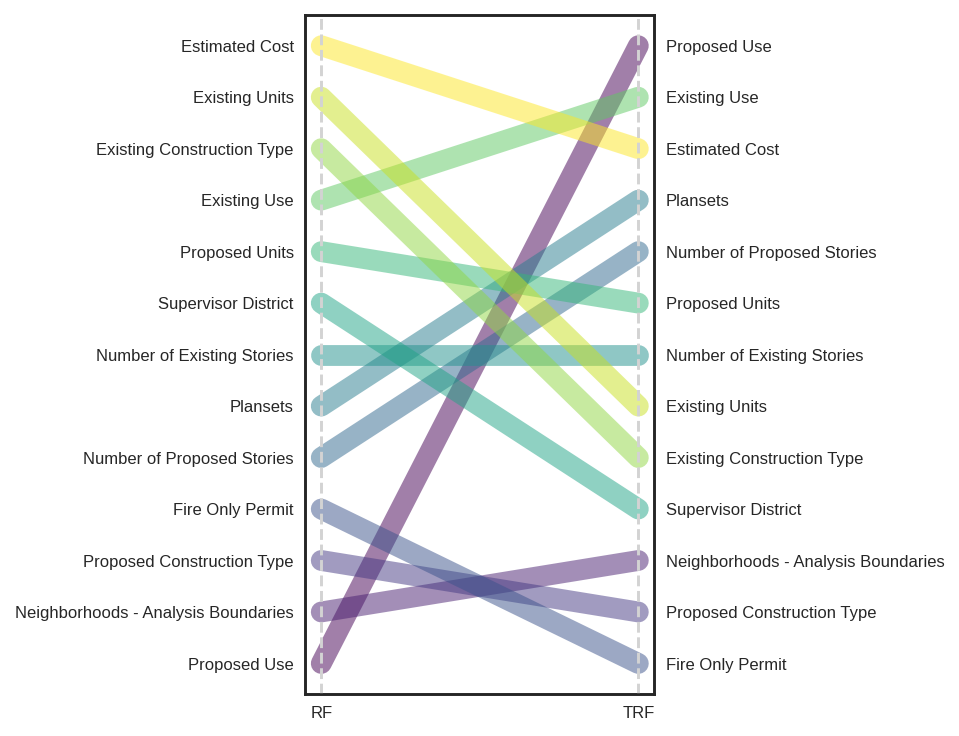

In [59]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

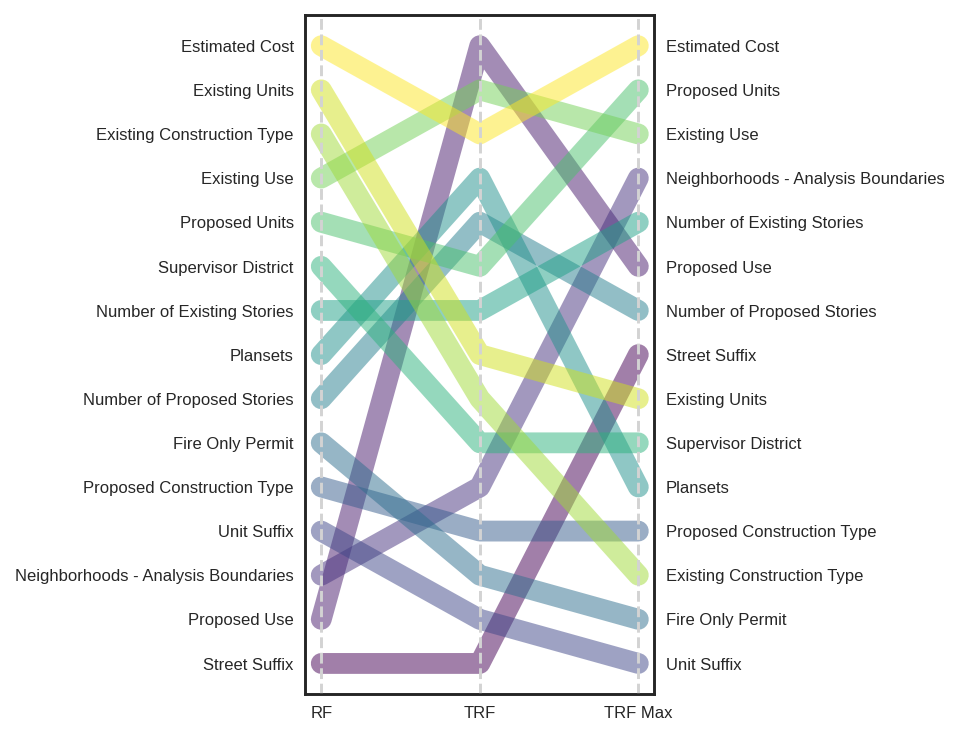

In [60]:
plot_shap_difference(all_models_importance, title="", save_as="../images/{}_importance_migration_trf_max.eps".format(PREFIX))

## Reverse Learning Curve

2015      2014          2013
Proposed Units                       0.019726  0.034747  5.146069e-02
Street Suffix                        0.003076  0.000898  1.040072e-04
Fire Only Permit                     0.002811  0.001053  2.808544e-03
Number of Existing Stories           0.019233  0.005845  1.561736e-02
Plansets                             0.043513  0.057622  6.507361e-02
Existing Units                       0.002771  0.007072  9.027480e-03
Neighborhoods - Analysis Boundaries  0.003948  0.002430  4.922680e-03
Proposed Construction Type           0.003261  0.001085  4.327573e-03
Existing Use                         0.094638  0.099077  1.221938e-01
Number of Proposed Stories           0.065518  0.011959  5.573766e-02
Estimated Cost                       0.092274  0.092459  9.114829e-02
Existing Construction Type           0.006273  0.005137  7.527510e-03
Supervisor District                  0.000968  0.003403  5.742769e-03
Unit Suffix                          0.000059  0.000000  4.440892e-17
Proposed Use                         0.081500  0.096909  1.340449e-01

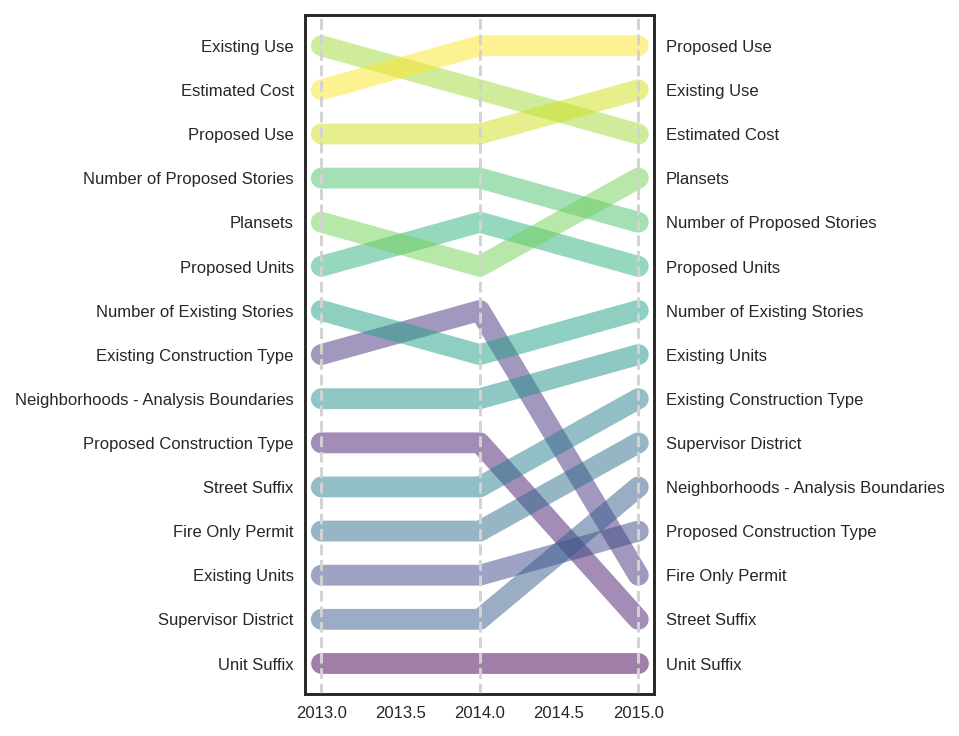

In [61]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

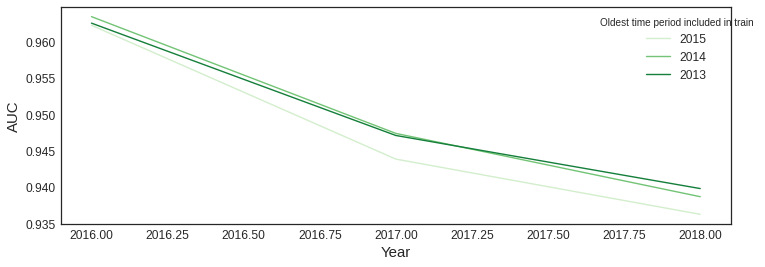

In [62]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

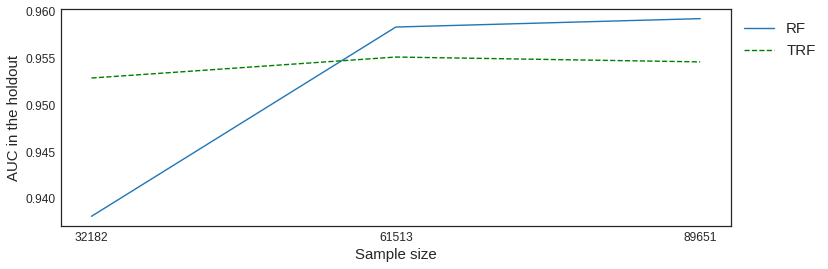

In [63]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

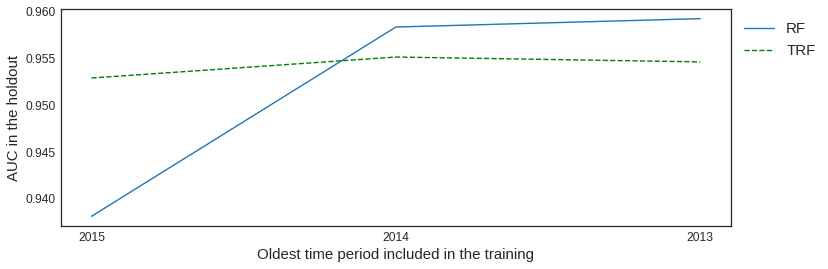

In [64]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

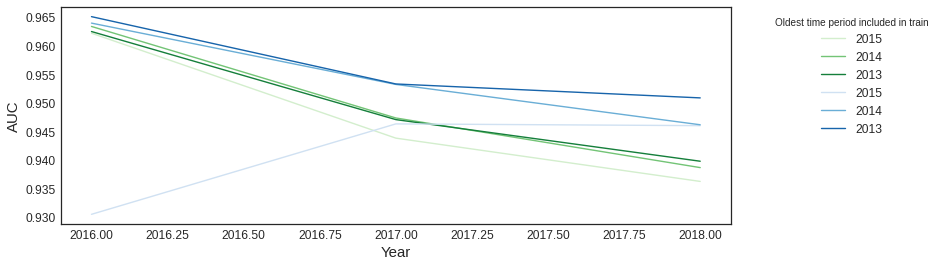

In [65]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

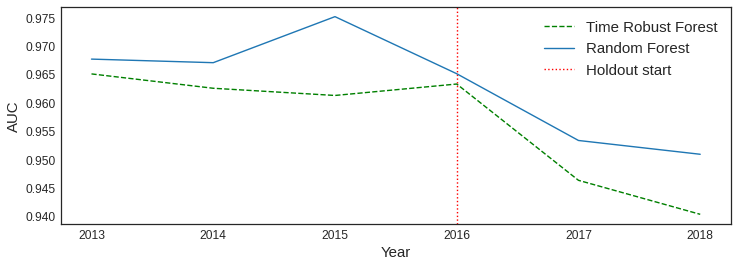

In [66]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

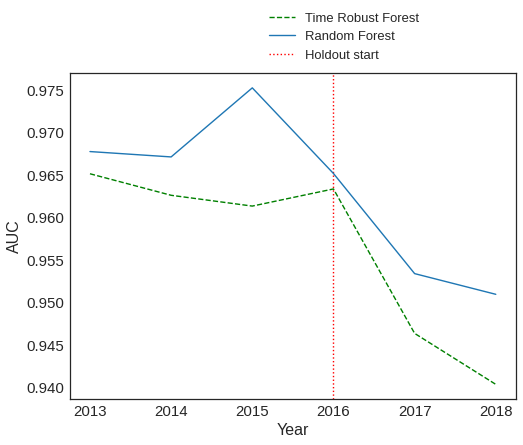

In [67]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, bbox_to_anchor=(0.42, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [68]:
challenger_model.feature_importance()

Estimated Cost                         1034
Proposed Units                          687
Existing Use                            619
Neighborhoods - Analysis Boundaries     605
Number of Existing Stories              586
Number of Proposed Stories              522
Proposed Use                            504
Existing Units                          475
Street Suffix                           450
Supervisor District                     419
Plansets                                341
Proposed Construction Type              239
Existing Construction Type              180
Fire Only Permit                        179
Unit Suffix                              26
Name: Feature Importance, dtype: int64

In [69]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance().index]
selected_features

['Proposed Units',
 'Street Suffix',
 'Fire Only Permit',
 'Number of Existing Stories',
 'Plansets',
 'Existing Units',
 'Neighborhoods - Analysis Boundaries',
 'Proposed Construction Type',
 'Existing Use',
 'Number of Proposed Stories',
 'Estimated Cost',
 'Existing Construction Type',
 'Supervisor District',
 'Unit Suffix',
 'Proposed Use']

In [70]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

['Estimated Cost',
 'Proposed Units',
 'Existing Use',
 'Neighborhoods - Analysis Boundaries',
 'Number of Existing Stories',
 'Number of Proposed Stories',
 'Proposed Use',
 'Existing Units',
 'Street Suffix']

In [71]:
selected_features

['Estimated Cost',
 'Proposed Units',
 'Existing Use',
 'Neighborhoods - Analysis Boundaries',
 'Number of Existing Stories',
 'Number of Proposed Stories',
 'Proposed Use',
 'Existing Units',
 'Street Suffix']

In [72]:
clf1 = setup(train[selected_features + [TARGET]], 
             target="target",
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

In [73]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [74]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [75]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.9773434257816698
0.9597364675696082
0.9372949786142958


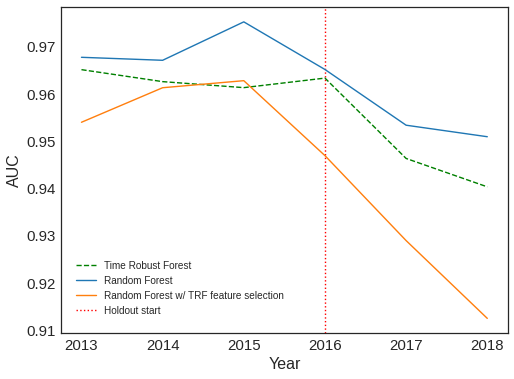

In [76]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="Random Forest w/ TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=10, bbox_to_anchor=(0.52, 0.25))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [77]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

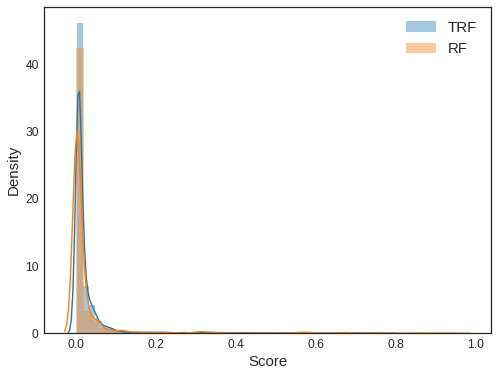

In [78]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction_opt"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [79]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction_opt"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

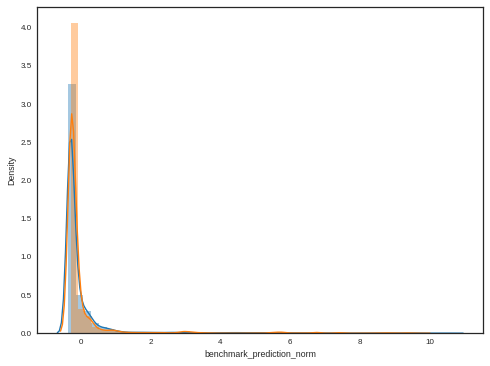

In [80]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(34725, 15)
(52089, 15)


In [82]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

['Proposed Units',
 'Number of Existing Stories',
 'Plansets',
 'Existing Units',
 'Proposed Construction Type',
 'Number of Proposed Stories',
 'Estimated Cost',
 'Existing Construction Type',
 'Supervisor District']

In [83]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [84]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

100% (11 of 11) |########################| Elapsed Time: 0:05:24 Time:  0:05:24
100% (11 of 11) |########################| Elapsed Time: 0:01:59 Time:  0:01:59


In [85]:
pred_test = gam_challenger.predict(X_test[features])
print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

pred_test = gam_benchmark.predict(X_test[features])
print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

r2 test (challenger): 0.590031
r2 test (benchmark): 0.563601


Proposed Units
0


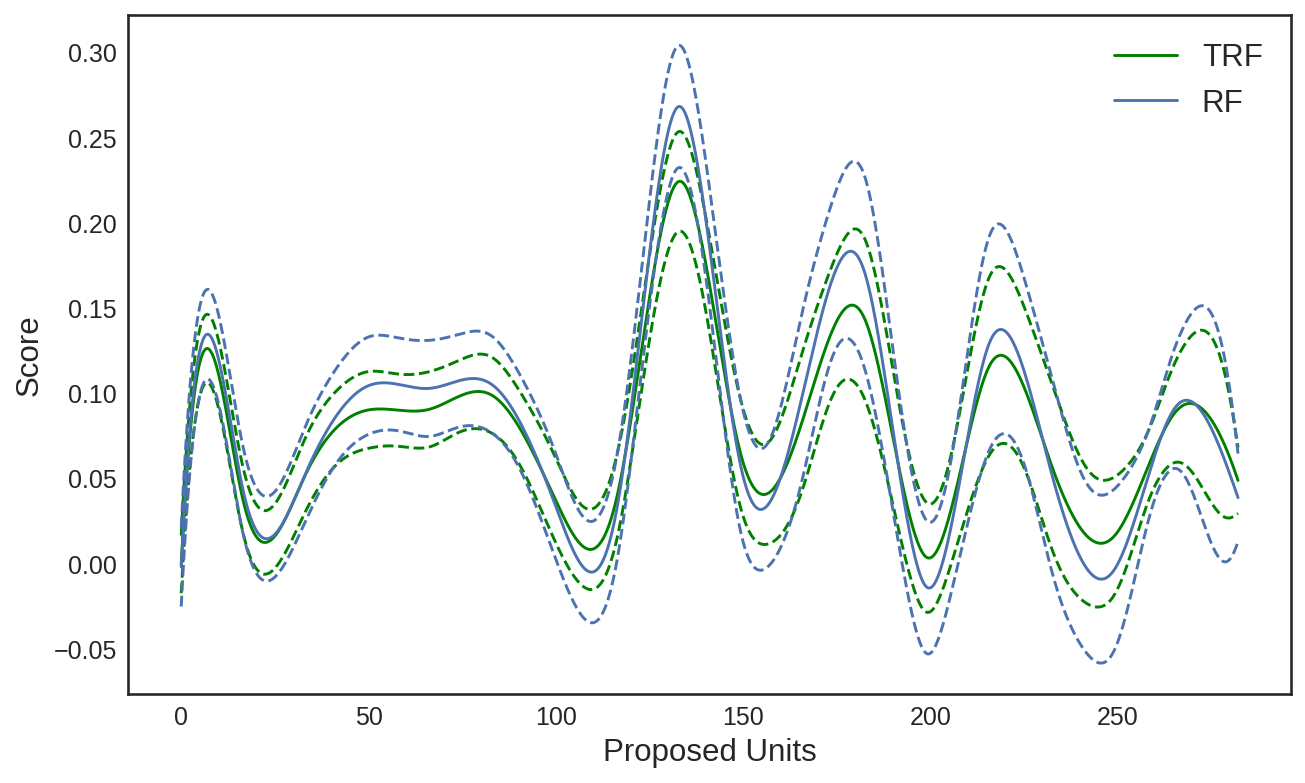

Number of Existing Stories
3


<Figure size 576x432 with 0 Axes>

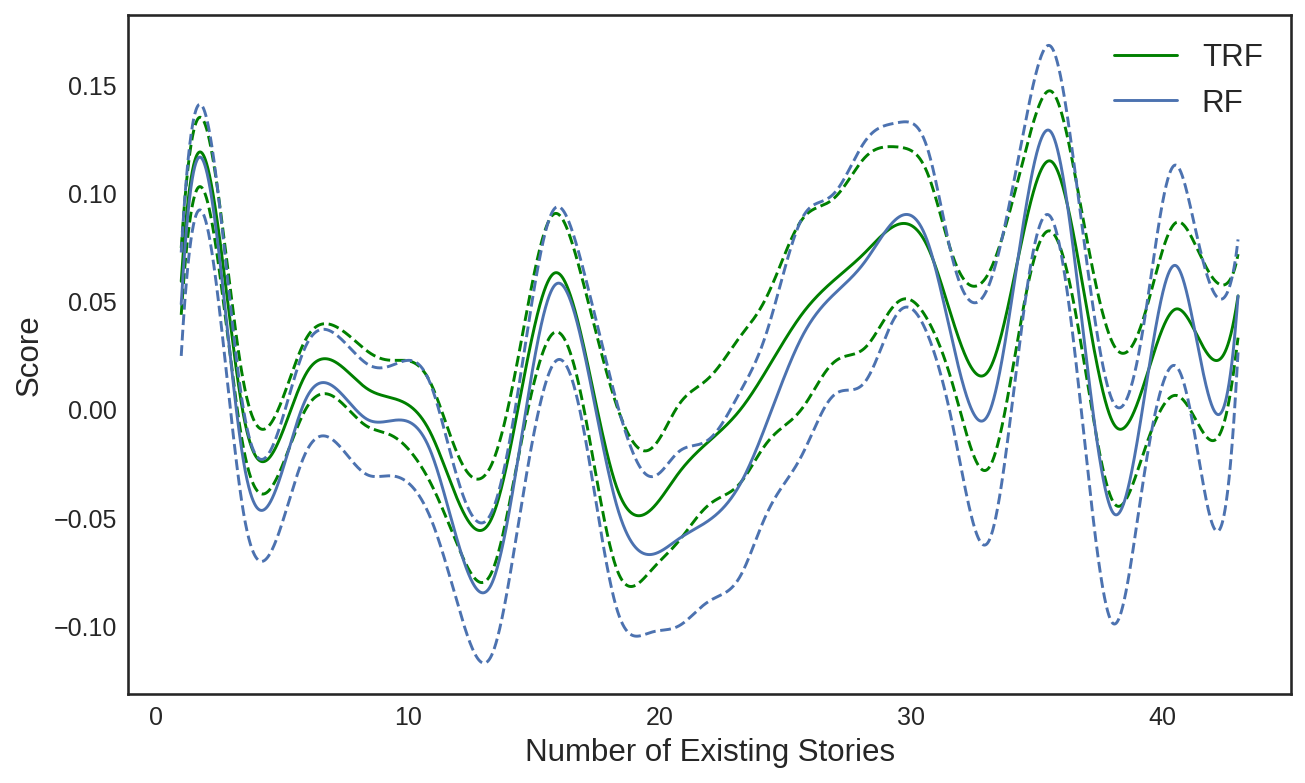

Plansets
4


<Figure size 576x432 with 0 Axes>

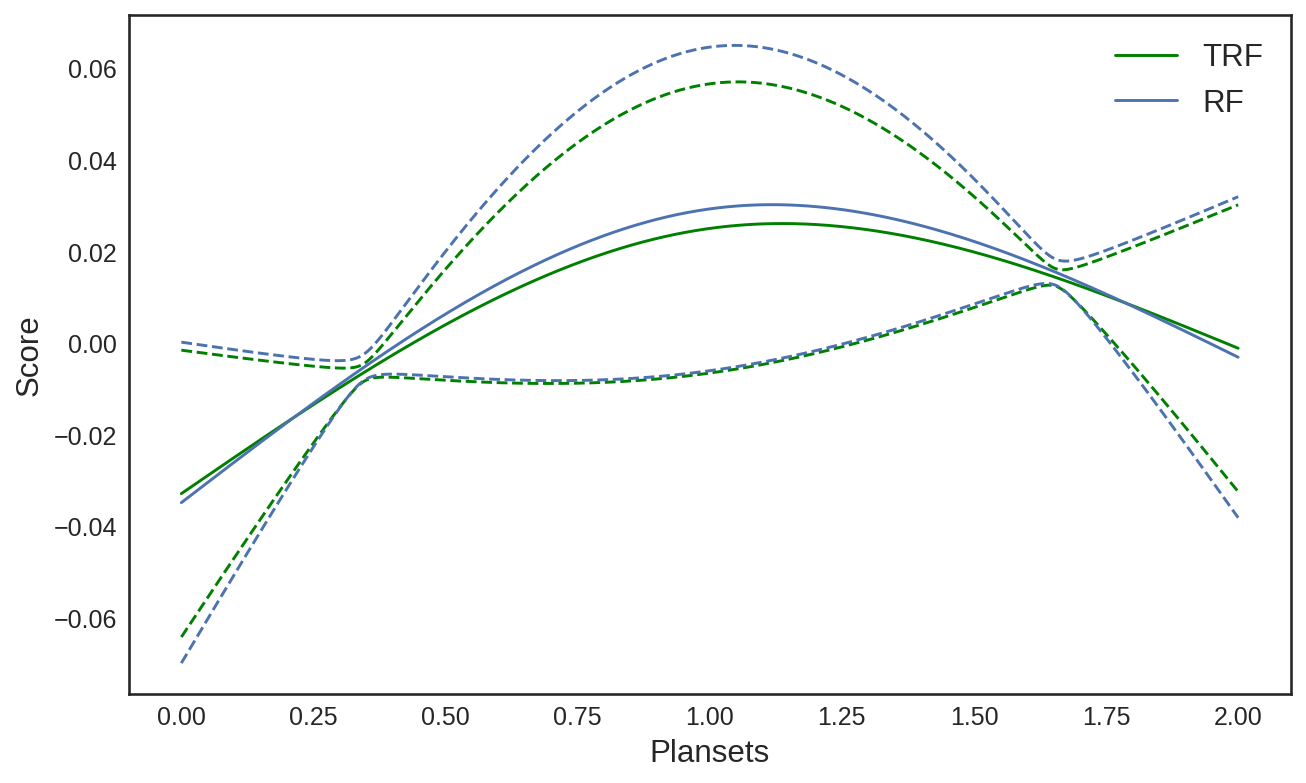

Existing Units
5


<Figure size 576x432 with 0 Axes>

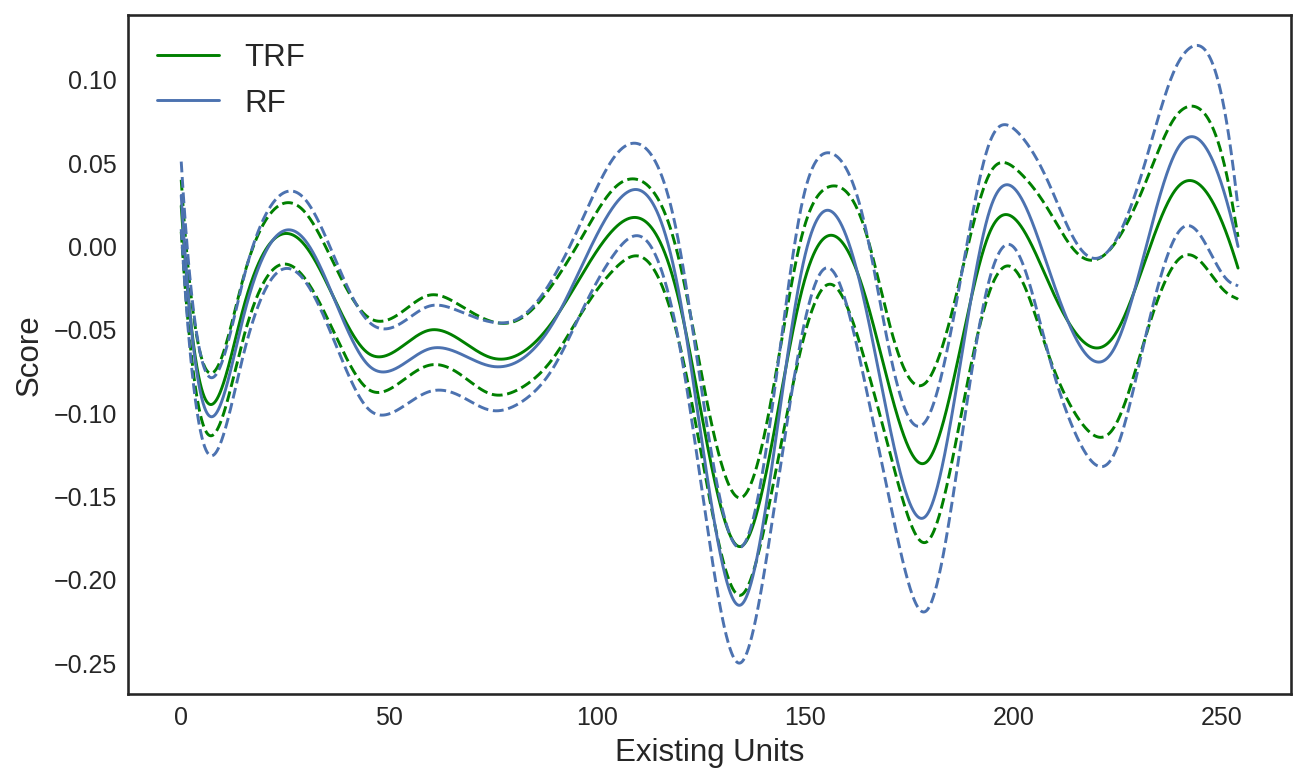

Proposed Construction Type
7


<Figure size 576x432 with 0 Axes>

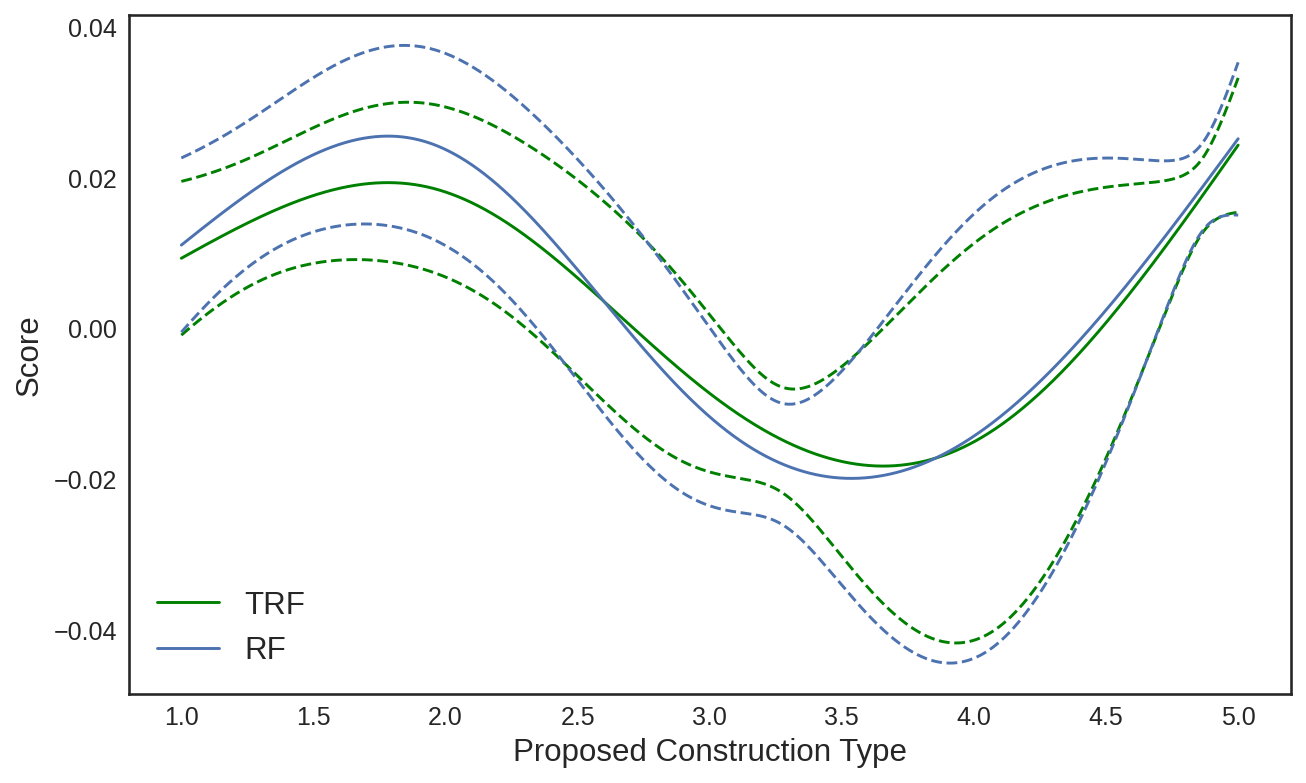

Number of Proposed Stories
9


<Figure size 576x432 with 0 Axes>

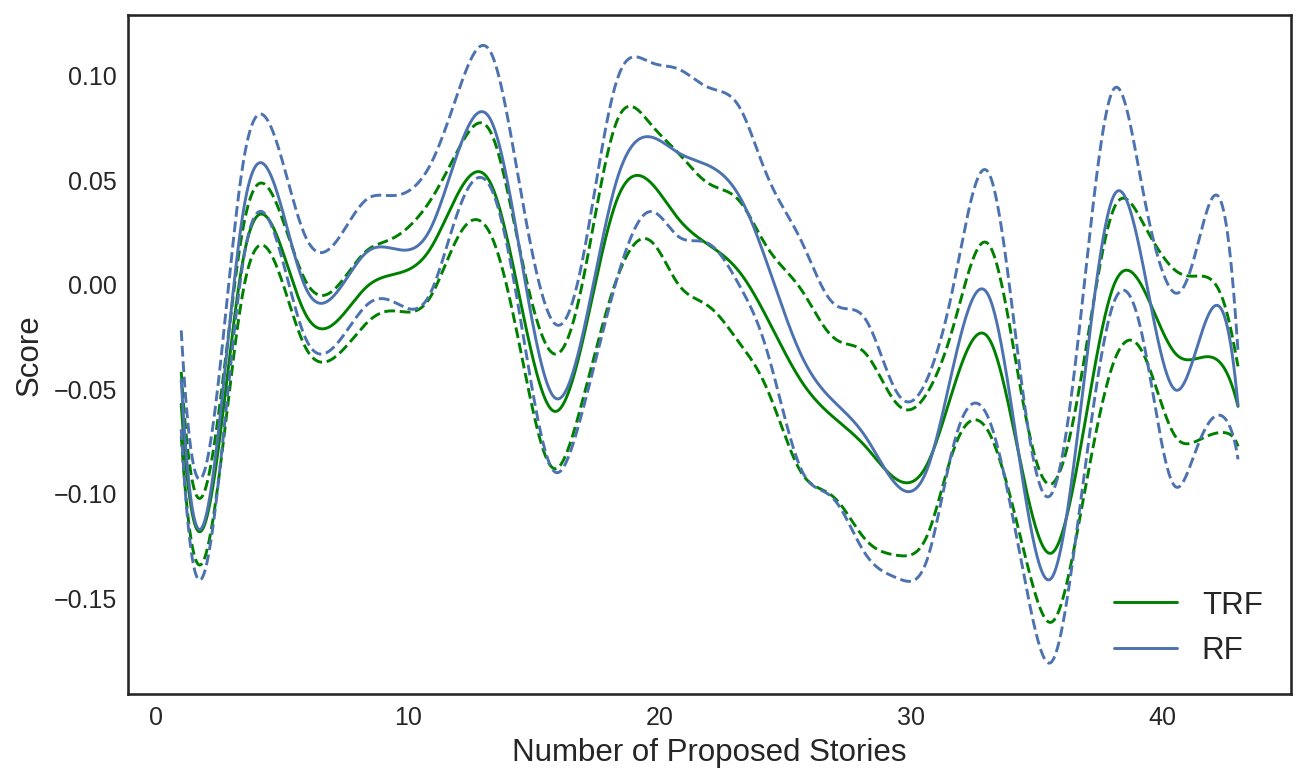

Estimated Cost
10


<Figure size 576x432 with 0 Axes>

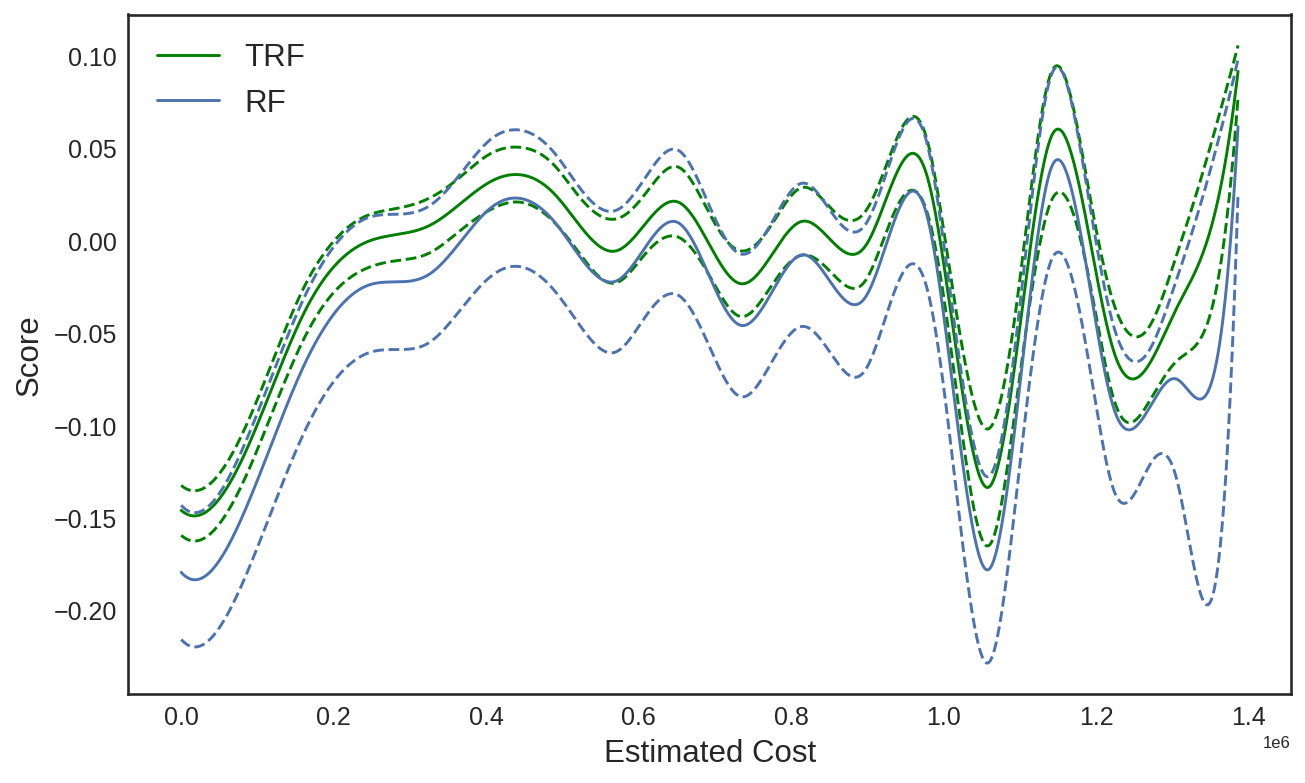

Existing Construction Type
11


<Figure size 576x432 with 0 Axes>

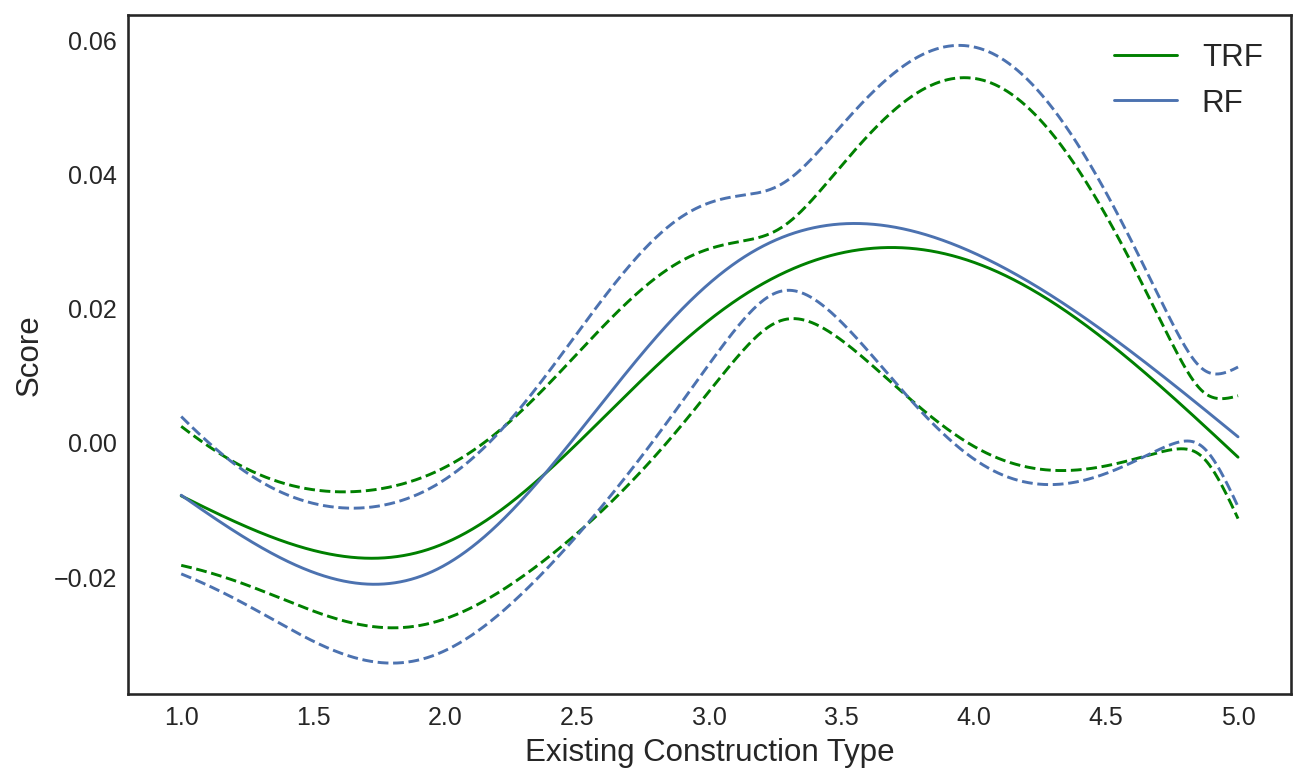

Supervisor District
12


<Figure size 576x432 with 0 Axes>

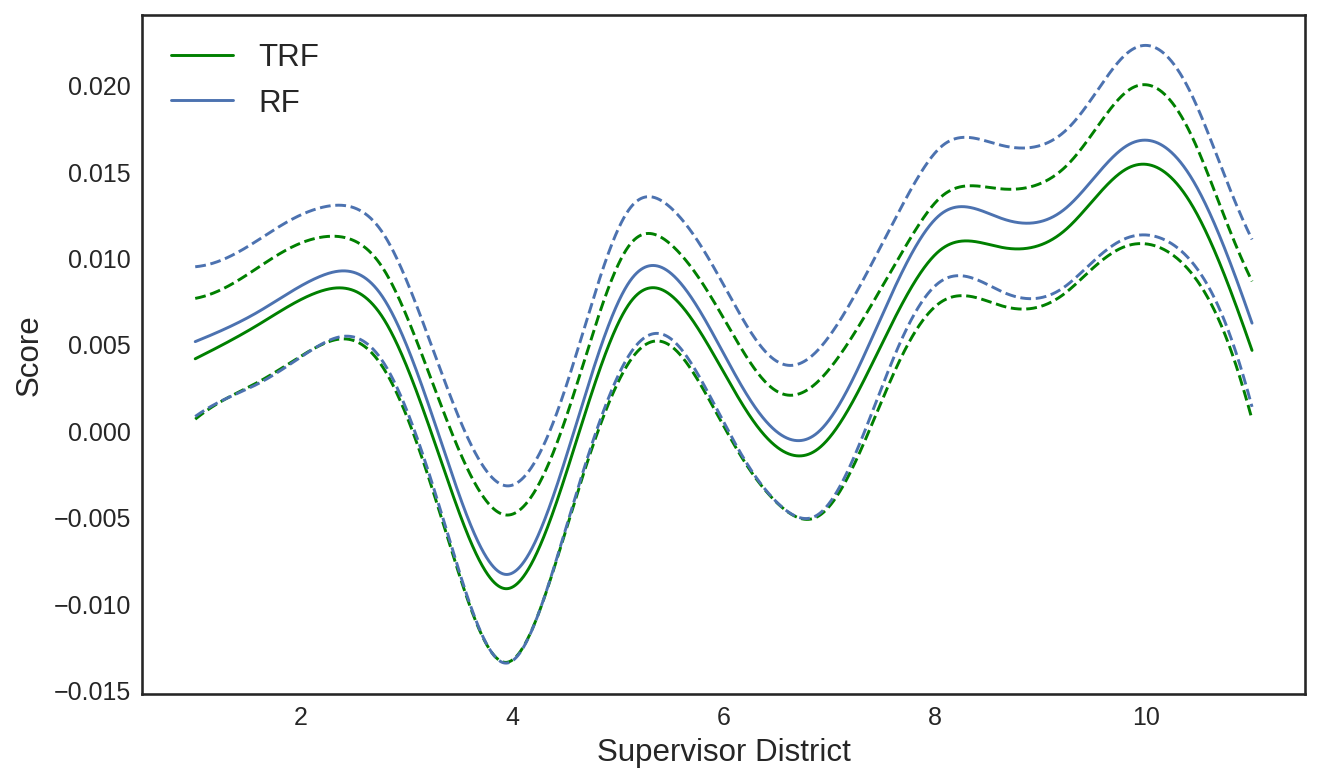

<Figure size 576x432 with 0 Axes>

In [87]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    XX[:, 13] = X_test.values[:, 13]
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

No handles with labels found to put in legend.


Street Suffix


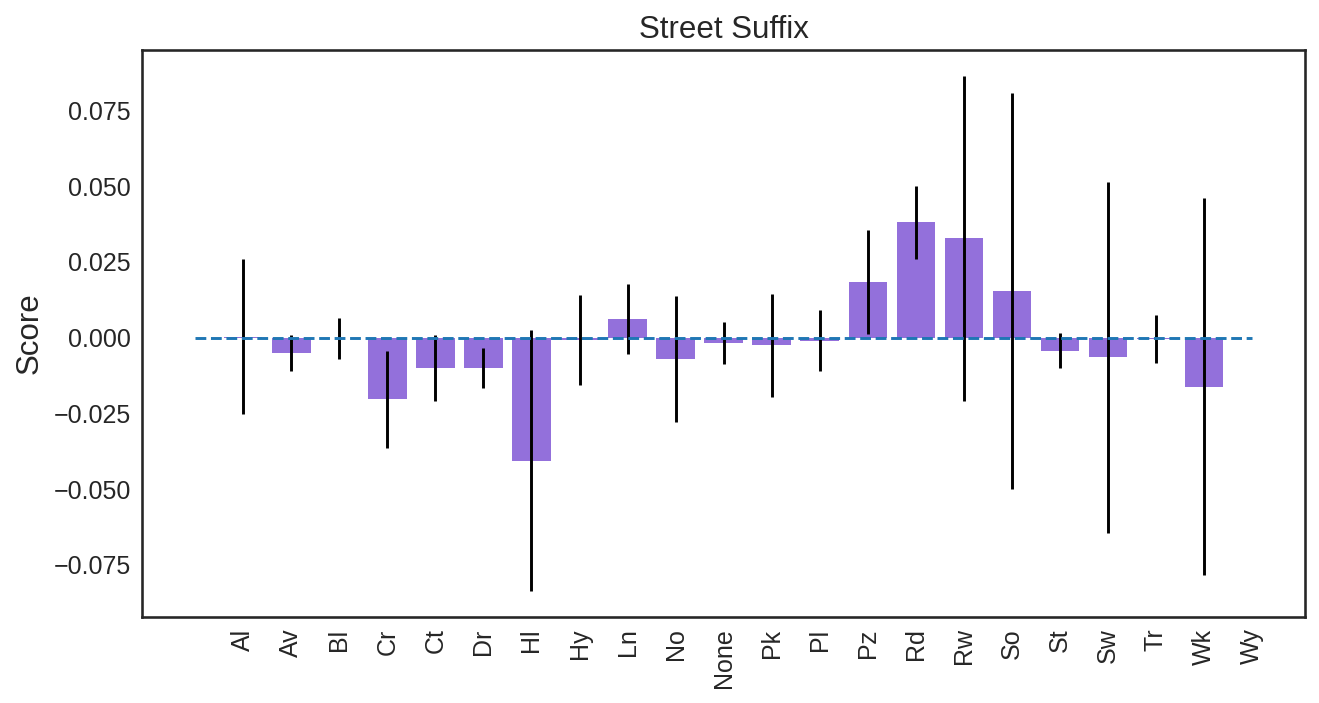

No handles with labels found to put in legend.


Fire Only Permit


<Figure size 576x432 with 0 Axes>

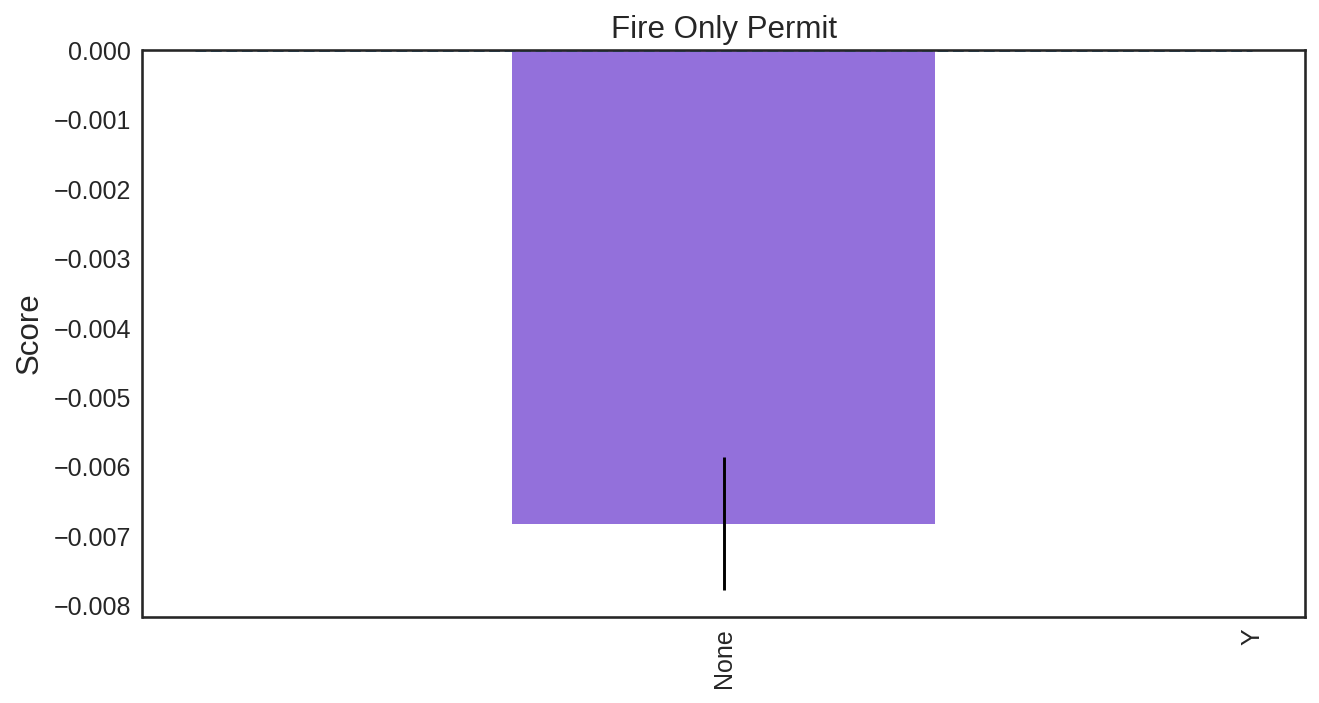

No handles with labels found to put in legend.


Neighborhoods - Analysis Boundaries


<Figure size 576x432 with 0 Axes>

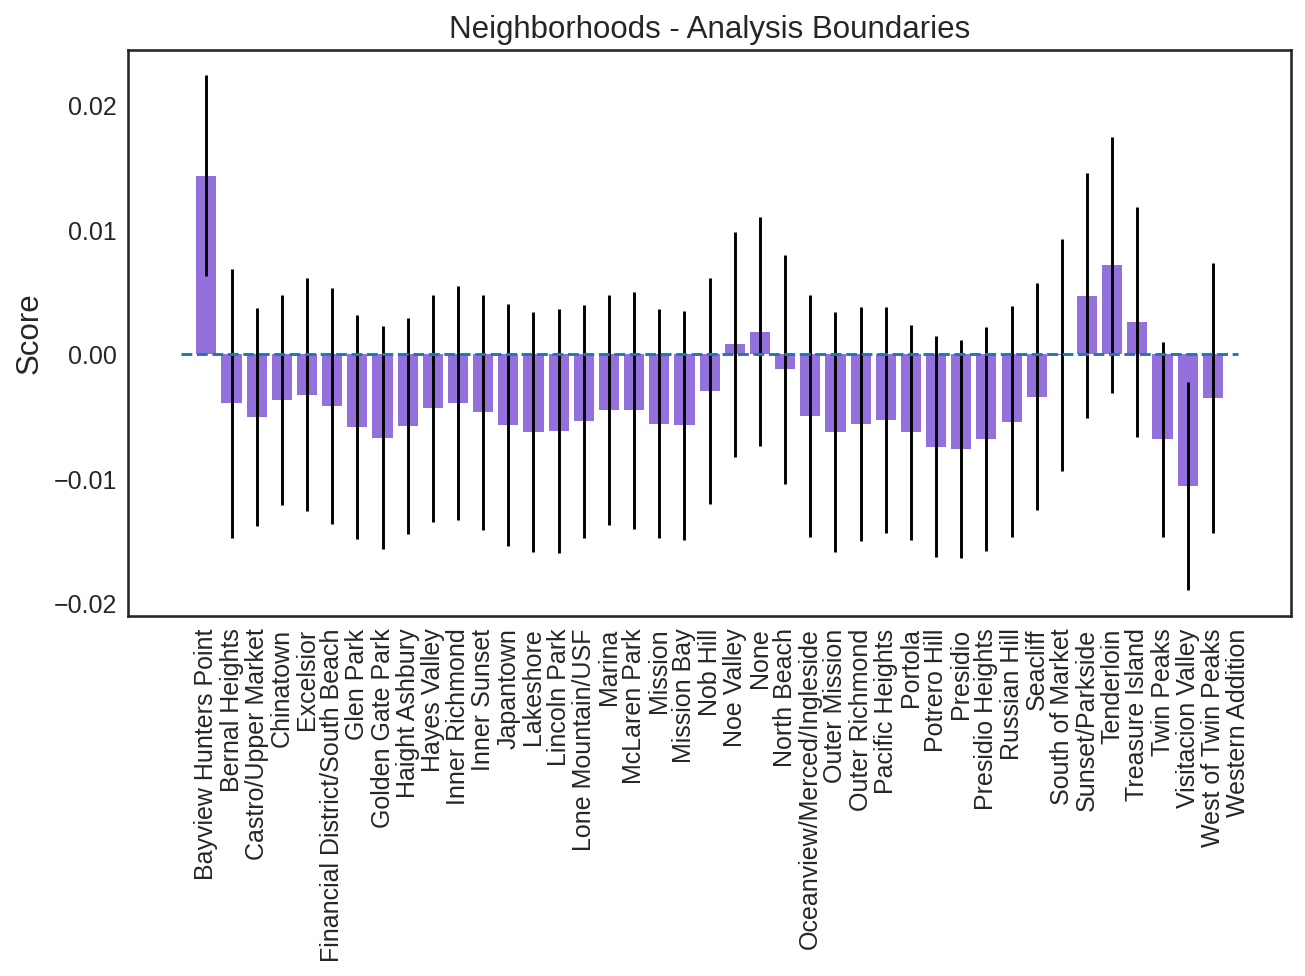

Existing Use


No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

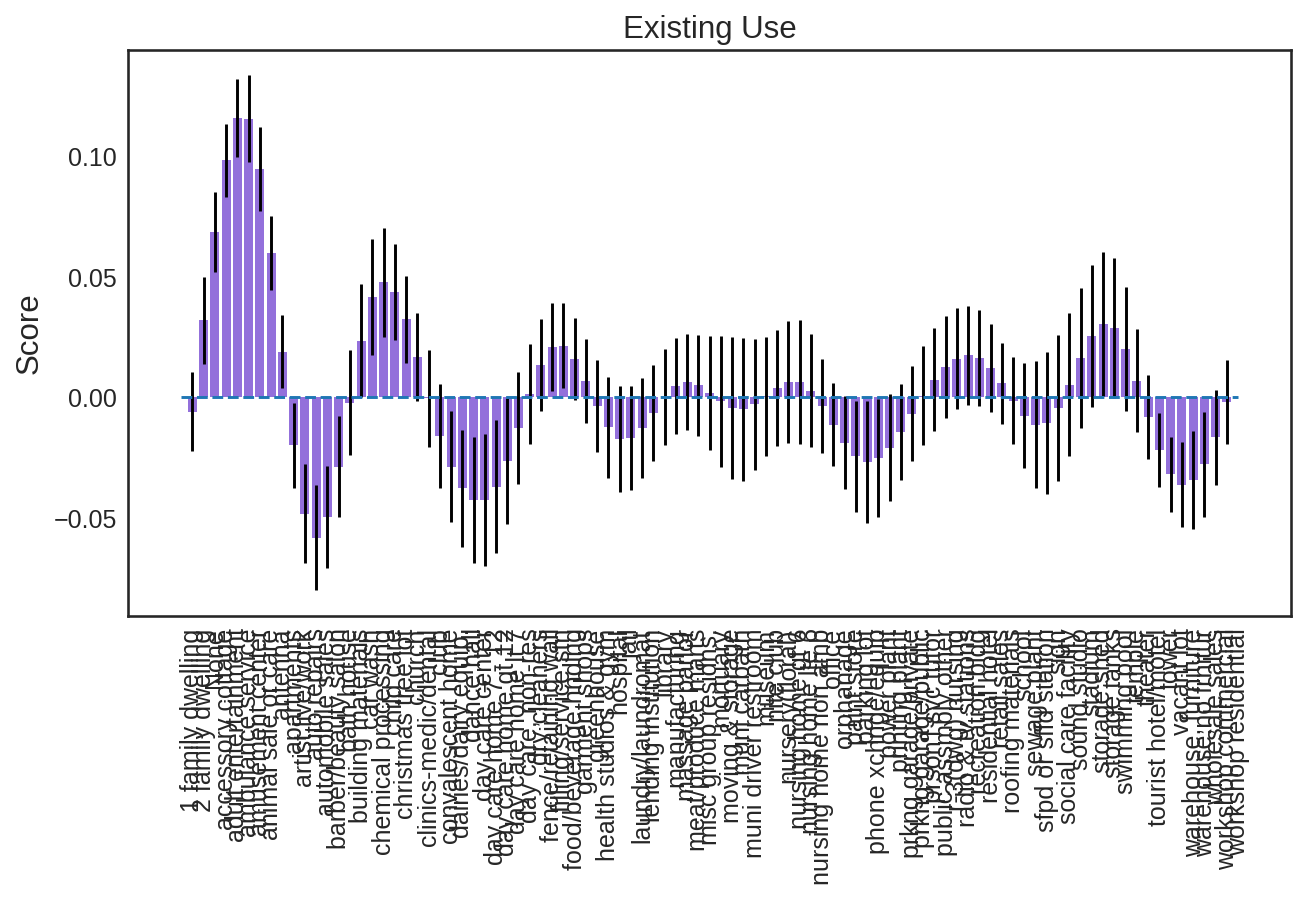

Unit Suffix
Proposed Use


No handles with labels found to put in legend.


<Figure size 576x432 with 0 Axes>

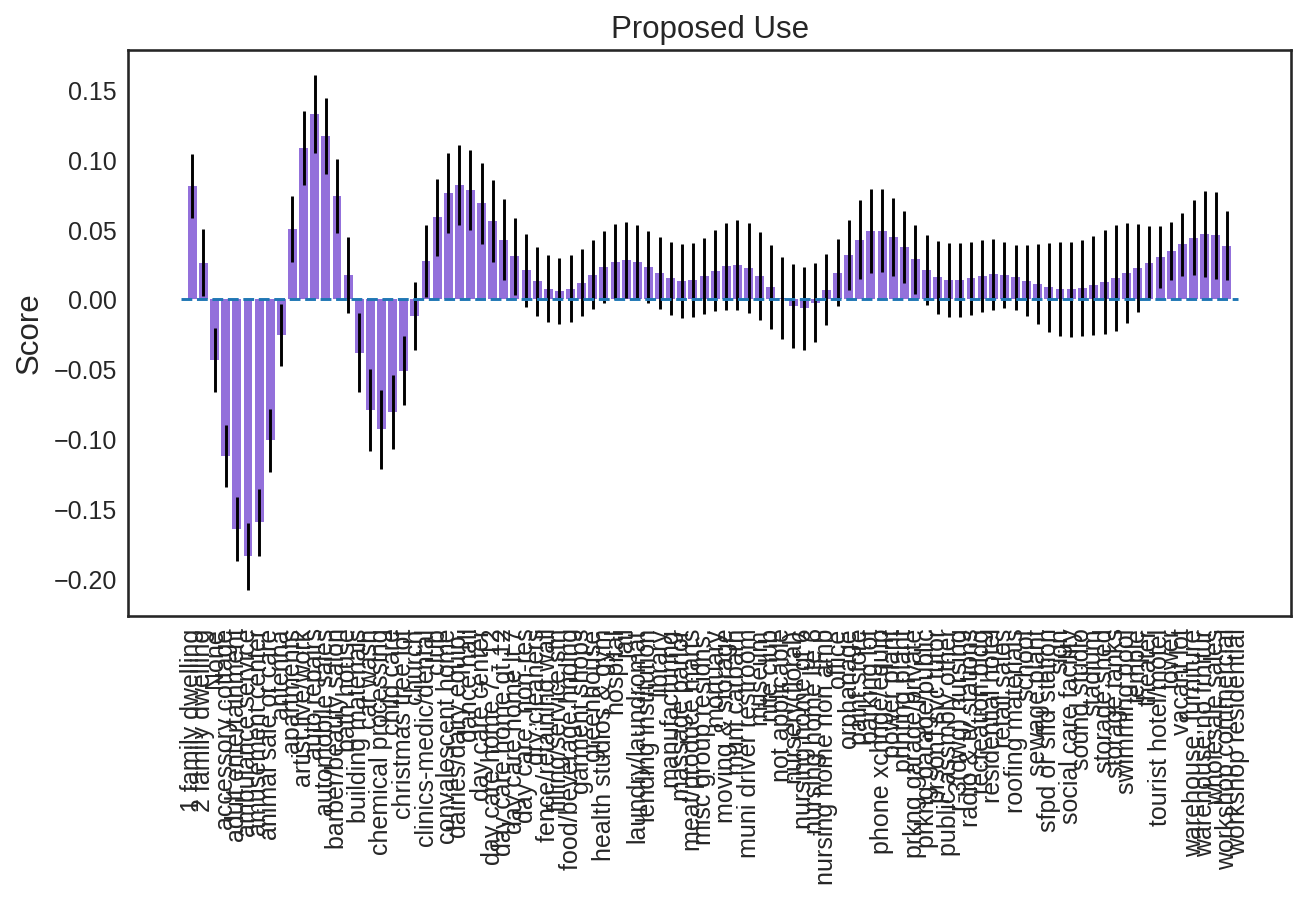

<Figure size 576x432 with 0 Axes>

In [88]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        try:
            mapping = encoder_mappings[feat]
            max_cat = np.max(list(mapping.keys()))
            if max_cat > 100:
                continue
            XX = np.copy(X_test)
            XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
            pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
            fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
            data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                                columns=[feat, "Mean Impact", "low", "high"])
            data["low"] = np.abs(data["low"] - data["Mean Impact"])
            data["high"] = np.abs(data["high"] - data["Mean Impact"])
            agg = data.groupby(feat).mean()

            impact_plot = plt.bar([i for i in range(len(agg))],
                                  agg["Mean Impact"],
                                  yerr=agg[["low", "high"]].values.transpose(),
                                  color="#9370DB",
                                  capsize=7)

            plt.title(feat, fontsize=15)
            plt.xticks([i for i in range(len(list(mapping.keys())))])
            ax.set_xticklabels(list(mapping.values()), rotation=90)
            plt.hlines(0.0, -1, max_cat, linestyles="dashed")
            plt.ylabel("Score", fontsize=15)

            ax.xaxis.set_tick_params(labelsize=12)
            ax.yaxis.set_tick_params(labelsize=12)
            xmin, xmax, ymin, ymax = plt.axis()
            plt.ylim([ymin, ymax])
            plt.legend(fontsize=15)
            plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

            plt.show()
            plt.clf()
        except:
            print("No plot for {}".format(feat))
plt.show()

Street Suffix


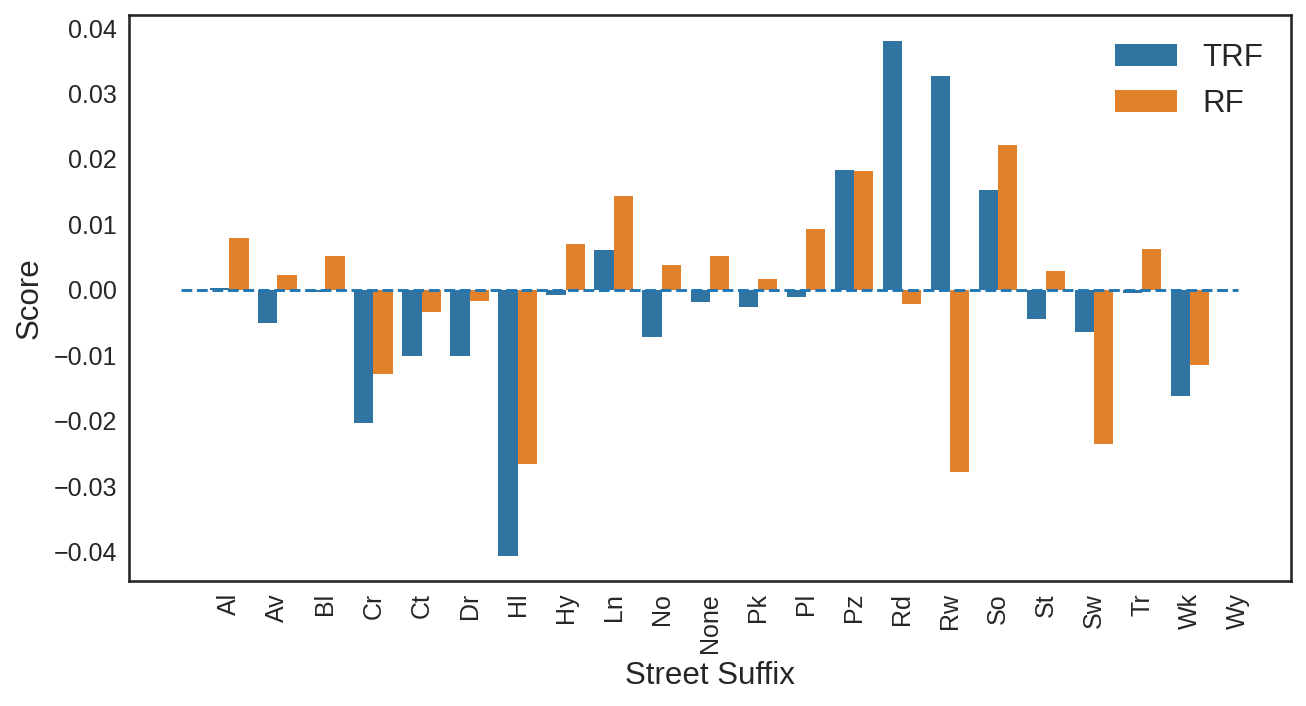

Fire Only Permit


<Figure size 576x432 with 0 Axes>

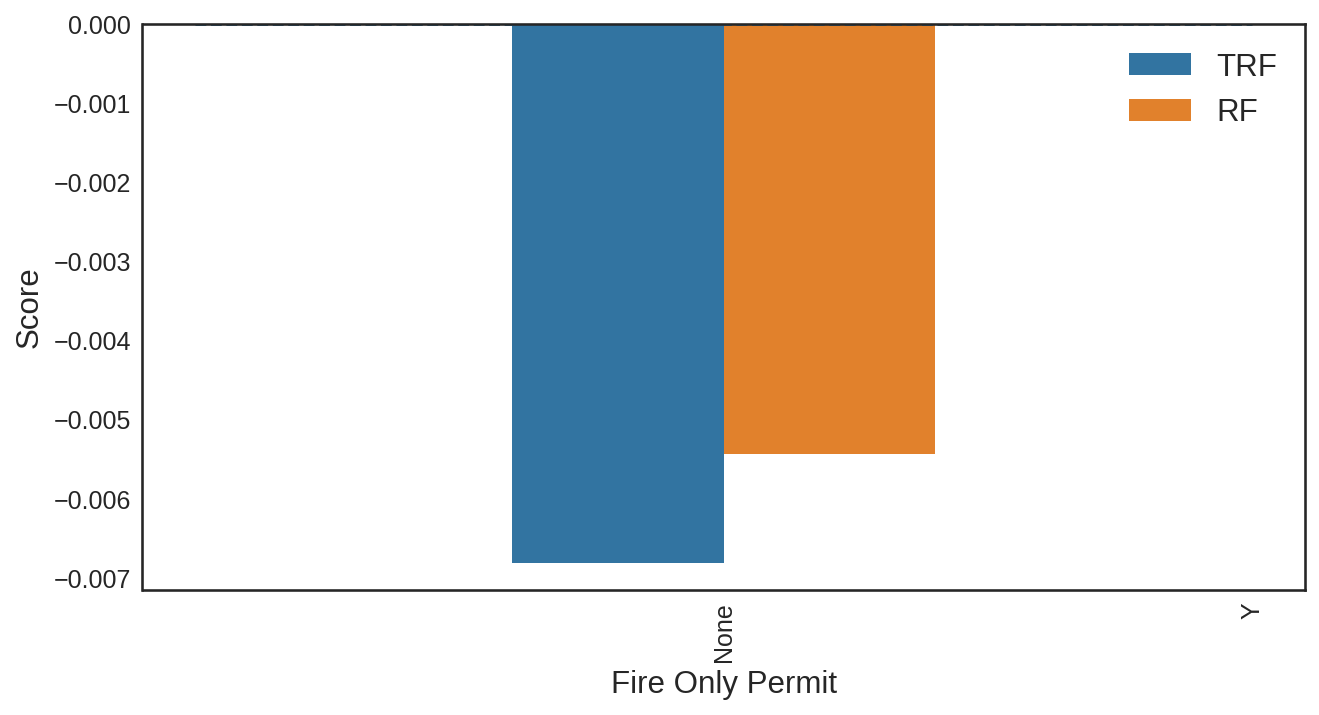

Neighborhoods - Analysis Boundaries


<Figure size 576x432 with 0 Axes>

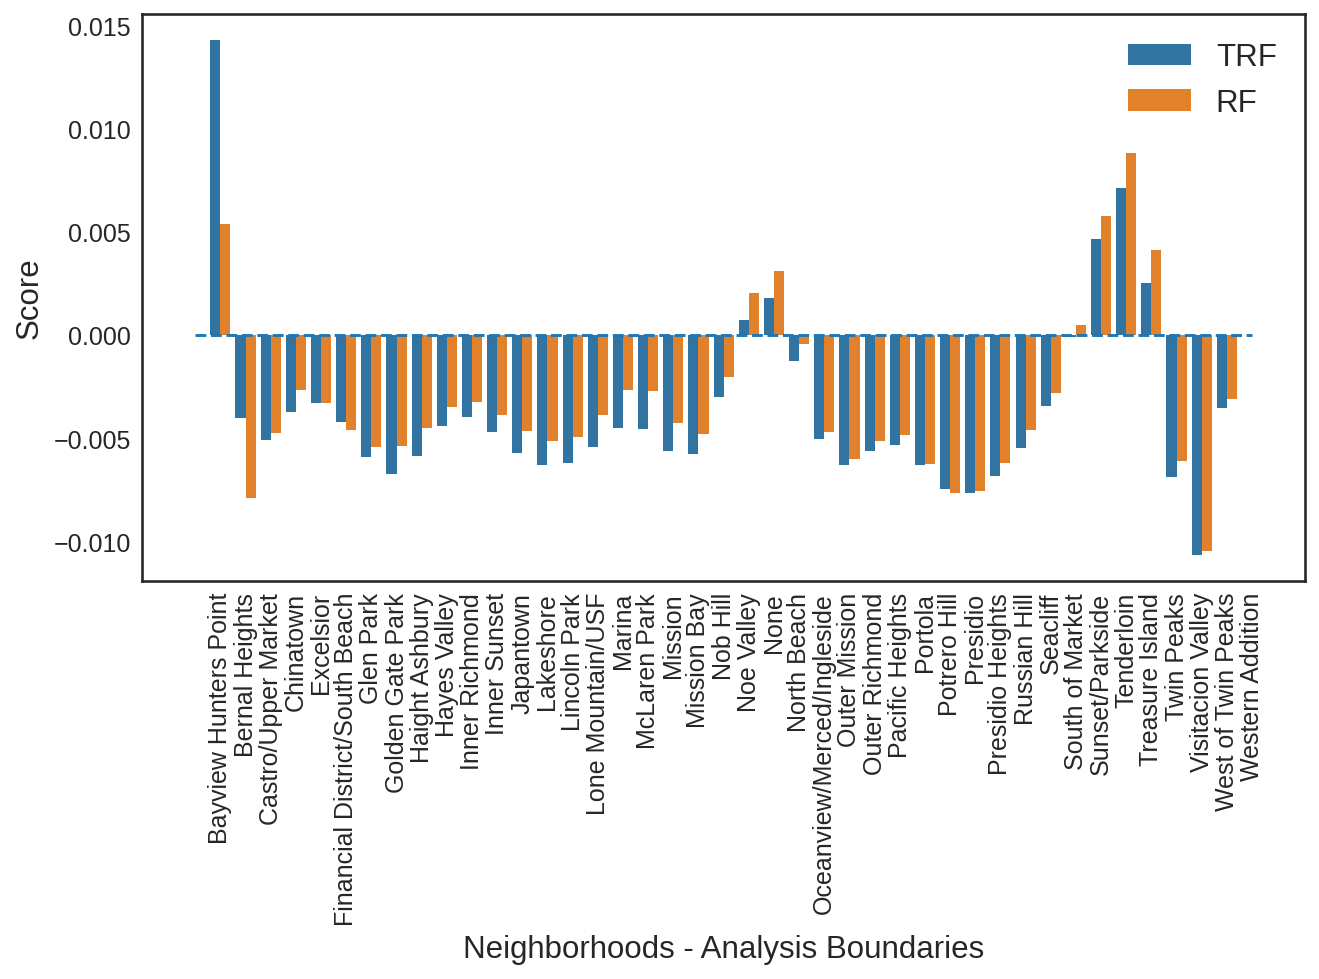

Existing Use


<Figure size 576x432 with 0 Axes>

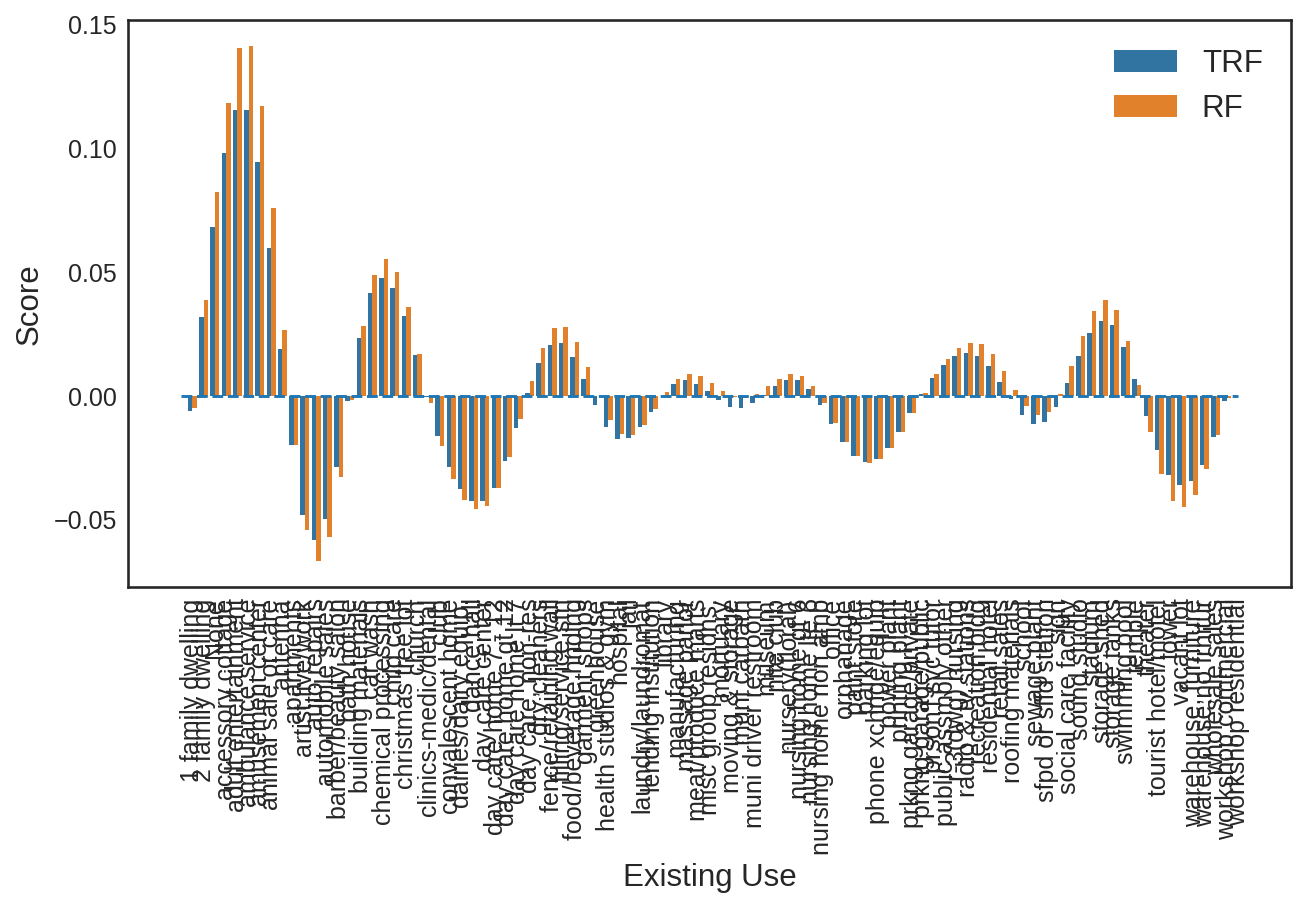

Unit Suffix
Proposed Use


<Figure size 576x432 with 0 Axes>

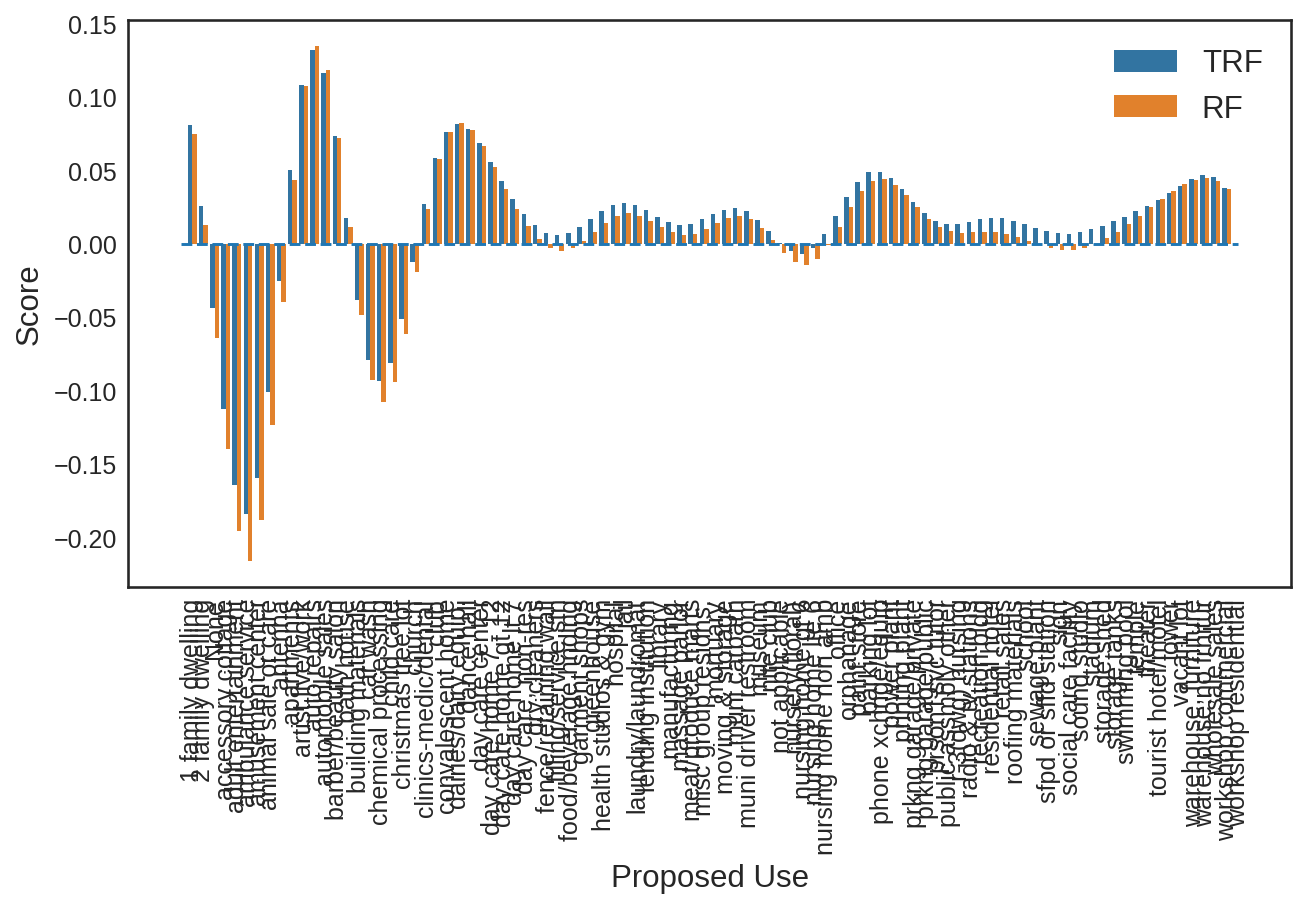

<Figure size 576x432 with 0 Axes>

In [89]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [90]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [91]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        n_estimators=CHALLENGER_N_ESTIMATORS,
                                        min_sample_periods=min_sample_periods,
                                        max_depth=CHALLENGER_MAX_DEPTH,
                                        multi=True)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

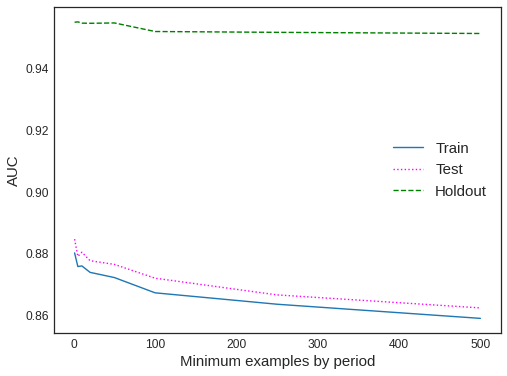

In [92]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

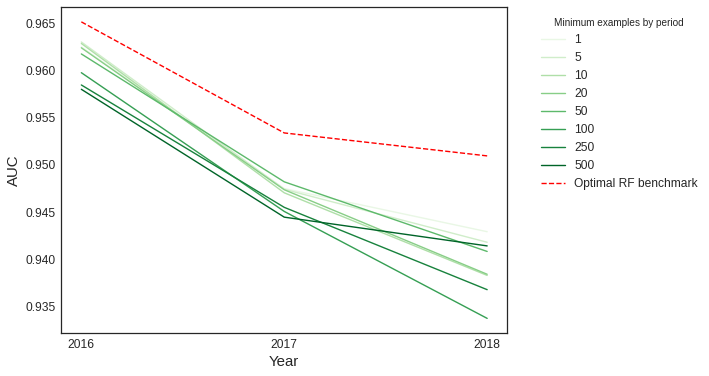

In [93]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [94]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = tuned_rf
    model.set_params(min_samples_leaf=training_segments * min_sample_periods)
    
    
    model.fit(train[features],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

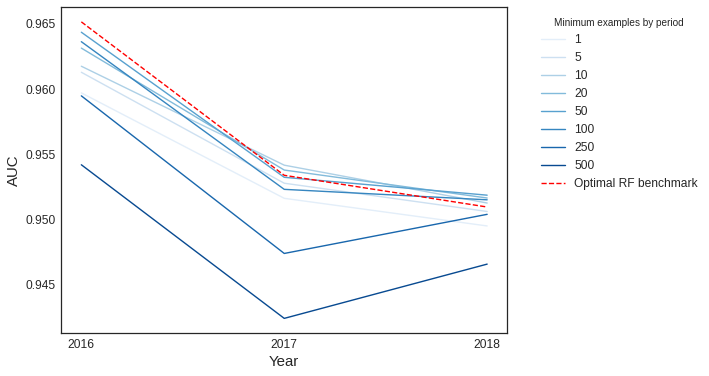

In [95]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction_opt"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

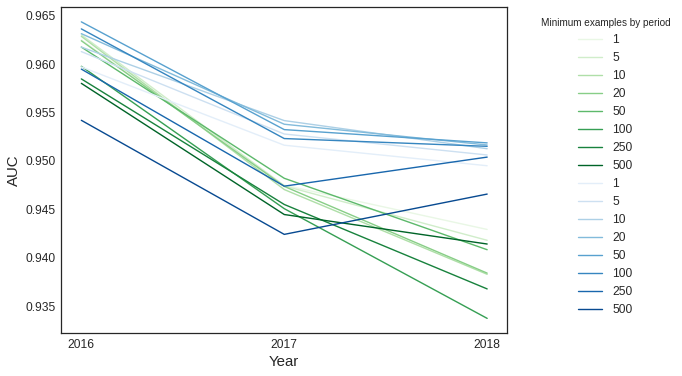

In [96]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

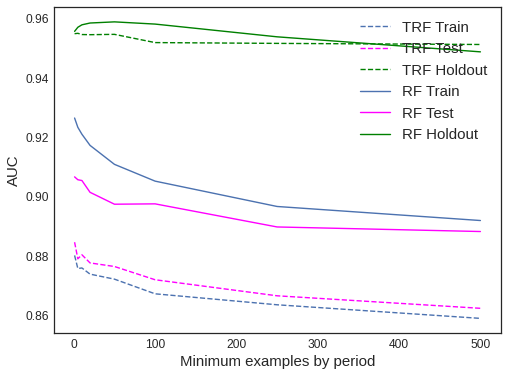

In [97]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

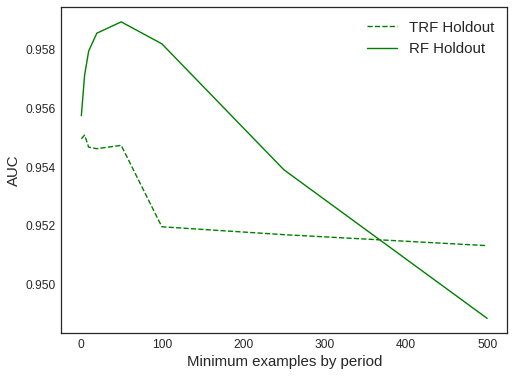

In [98]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [99]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [100]:
domain_data = pd.concat([train, test, out_of_time])

In [101]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [102]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

In [103]:
domain_model = tuned_domain_rf

In [104]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=9, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=5,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=124, verbose=0, warm_start=False)

In [105]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [106]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.6054509123389988

## Other optimization design for the RF

In [107]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

2015

In [108]:
posfix = str(last_time_segment_in_train)

In [109]:
new_train = in_time[in_time["Year"] < last_time_segment_in_train]
new_validation = in_time[in_time["Year"] == last_time_segment_in_train]

In [110]:
clf1 = setup(new_train[features + [TARGET]], target="target",
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [111]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=240,
                       n_jobs=-1, oob_score=False, random_state=44, verbose=0,
                       warm_start=False)

In [112]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [113]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [114]:
clf1 = setup(new_train[features + [TARGET]], target="target",
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [115]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

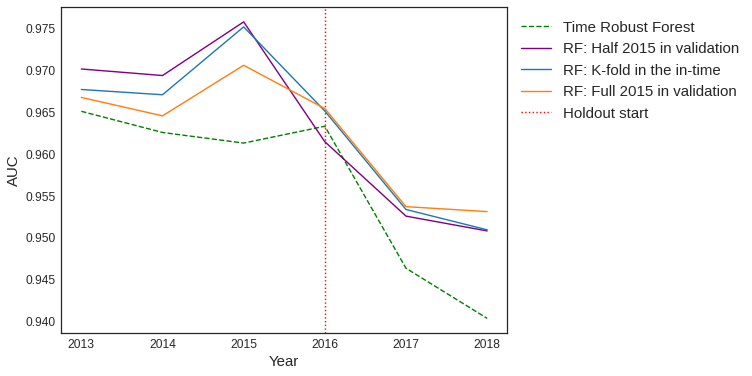

In [116]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()
